# Creating a basic Cluster Expansion

In [1]:
import numpy as np
import json
from pymatgen.core import Structure
from smol.cofe import ClusterSubspace, StructureWrangler, ClusterExpansion
from smol.cofe.space import Cluster
from smol.cofe.extern import EwaldTerm

import matplotlib.pyplot as plt
import matplotlib
import pickle


In [2]:
prim = Structure.from_file('./DataSet_forTest/LiF.cif')
ro = {'Li+':{'Li+':1/3, 'Mn3+':1/3, 'Ti4+':1/3 }, 'F-':{'O2-': 1/2, 'F-': 1/2}}

prim.replace_species(ro)

In [3]:
subspace = ClusterSubspace.from_cutoffs(prim,
                                      cutoffs={2: 7.1, 3: 4, 4:4}, # will include orbits of 2 and 3 sites.
                                      basis='sinusoid',
                                      supercell_size='volume')

# supercell_size specifies the method to determine the supercell size
# when trying to match a structure.
# (See pymatgen.structure_mathcer.StructureMatcher for more info)

subspace.add_external_term(EwaldTerm(eta=None))

print(subspace) # single site and empty orbits are always included.

ClusterBasis: [Prim Composition] Li+0.33333333 Mn3+0.33333333 Ti4+0.33333333 O2-0.5 F-0.5
    [Size] 0
      [Orbit] id: 0  orderings: 1
    [Size] 1
      [Orbit] id: 1  orderings: 2   multiplicity: 1    no. symops: 48  
        [SiteSpace: Li0.33333333 Ti0.33333333 Mn0.33333333]
        [Base Cluster] Radius: 0.0   Centroid: [0. 0. 0.]         Points: [[0. 0. 0.]]         
      [Orbit] id: 2  orderings: 1   multiplicity: 1    no. symops: 48  
        [SiteSpace: O0.5 F0.5]
        [Base Cluster] Radius: 0.0   Centroid: [0.5 0.5 0.5]      Points: [[0.5 0.5 0.5]]      
    [Size] 2
      [Orbit] id: 3  orderings: 2   multiplicity: 6    no. symops: 8   
        [SiteSpace: Li0.33333333 Ti0.33333333 Mn0.33333333, SiteSpace: O0.5 F0.5]
        [Base Cluster] Radius: 1.05  Centroid: [0.75 0.75 0.25]   Points: [[1.  1.  0. ]  [0.5 0.5 0.5]]            
      [Orbit] id: 4  orderings: 3   multiplicity: 6    no. symops: 8   
        [SiteSpace: Li0.33333333 Ti0.33333333 Mn0.33333333, SiteSpa

In [5]:
with open('./DataSet_forTest/A_valid_7_4_4_MnTiOF_fromBin_sinusoid', 'rb') as fp:
    A_valid = pickle.load(fp)

with open('./DataSet_forTest/f_valid_7_4_4_MnTiOF_fromBin_sinusoid', 'rb') as fp:
    f_valid = pickle.load(fp)


## Optimization started here

In [6]:
from regression.gurobi_optimization import l0l1_diretct_optimize, l0l2_hierarchy_optimize_quicksum


In [7]:
correlated_ID = subspace.function_hierarchy(min_size=2, invert= True)
print(correlated_ID)

[[], [], [], [], [49, 48, 46, 39, 37, 36], [51, 50, 47, 40, 38, 37], [48, 42, 41, 36], [50, 49, 43, 42, 37], [51, 44, 43, 38], [47, 46, 45, 40, 39], [50, 48, 46], [51, 49, 47], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [72, 71, 67, 58, 53, 52], [74, 73, 69, 68, 59, 54, 53], [76, 75, 70, 60, 55, 54], [77, 69, 67, 59, 58, 56], [78, 70, 68, 60, 59, 57], [71, 62, 61, 52], [73, 72, 63, 62, 53], [75, 74, 64, 63, 54], [76, 65, 64, 55], [78, 77, 66, 57, 56], [80, 79, 77, 68, 67], [81, 80, 78, 70, 69], [79, 73, 71, 67], [80, 74, 72, 69], [80, 75, 73, 68], [81, 76, 74, 70], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [8]:
ecis_gurobi_L0L1 = l0l1_diretct_optimize(A= A_valid, f= f_valid, mu0= 1e-4, mu1= 1e-4)

Academic license - for non-commercial use only - expires 2022-07-15
Using license file /Users/zhongpc/gurobi.lic
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter PSDTol to 1e-05
   Prev: 1e-06  Min: 0.0  Max: inf  Default: 1e-06


In [9]:
ecis_gurobi_L0L2_noHierarchy, _ = l0l2_hierarchy_optimize_quicksum(A= A_valid, f=f_valid, mu0= 1e-4, mu2= 1e-4,
                                                                 correlateID= None)


ecis_gurobi_L0L2_withHierarchy, _ = l0l2_hierarchy_optimize_quicksum(A= A_valid, f=f_valid, mu0= 1e-4, mu2= 1e-4,
                                                                 correlateID= correlated_ID)

Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Parameter PSDTol unchanged
   Value: 1e-06  Min: 0.0  Max: inf  Default: 1e-06
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Parameter PSDTol unchanged
   Value: 1e-06  Min: 0.0  Max: inf  Default: 1e-06


In [10]:
from regression import L1L0, L2L0

In [11]:
L1L0_opt = L1L0(alpha= 0.0001, l0_ratio = 0.5)  # one can try either alpha = 0.0001 or 0.0002
L1L0_opt.fit(X=A_valid, y= f_valid )
ecis_CVX_L0L1 = L1L0_opt.coef_ 

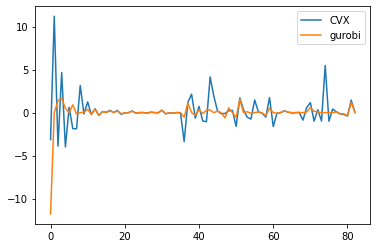

Non-Zero element in CVX method:  83
Non-Zero element in gurobi method:  67


In [12]:
plt.plot(ecis_CVX_L0L1, label ='CVX')
plt.plot(ecis_gurobi_L0L1, label ='gurobi')
plt.legend()
plt.show()

print("Non-Zero element in CVX method: ", np.sum(np.abs(ecis_CVX_L0L1) > 1e-6))
print("Non-Zero element in gurobi method: ", np.sum(np.abs(ecis_gurobi_L0L1) > 1e-6))

In [13]:
L2L0_opt = L2L0(alpha= 0.0001, l0_ratio = 0.5)
L2L0_opt.fit(X=A_valid, y= f_valid )
ecis_CVX_L0L2 = L2L0_opt.coef_ 

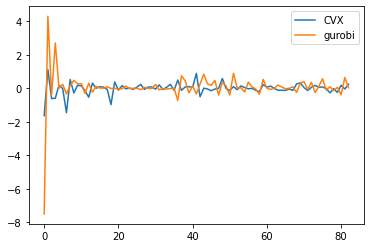

Non-Zero element in CVX method:  83
Non-Zero element in gurobi method:  83


In [14]:
plt.plot(ecis_CVX_L0L2, label ='CVX')
plt.plot(ecis_gurobi_L0L2_noHierarchy, label = 'gurobi')
plt.legend()
plt.show()

print("Non-Zero element in CVX method: ", np.sum(np.abs(ecis_CVX_L0L2) > 1e-6))
print("Non-Zero element in gurobi method: ", np.sum(np.abs(ecis_gurobi_L0L2_noHierarchy) > 1e-6))

# Summary

* From the current test results, gurobi and CVX do not show the same solution.
* This inconsistency does not mean either CVX or gurobi is wrong.
* The result indicates one should be careful with the definition in the funciton, even though they are the same in principle